In [1]:
# pip install shapely

In [2]:
import os; import pathlib as pl ; import flopy ; import git ; import matplotlib.pyplot as plt ; import pandas as pd 
import numpy as np ; from flopy.plot.styles import styles  ; from modflow_devtools.misc import get_env, timed ; from pathlib import Path
import matplotlib as mpl; import csv; from shapely.geometry import Polygon; from flopy.utils.gridintersect import GridIntersect

In [3]:
sim_name = "ex-gwf-advtidal" ; output_folder = Path("./04_advtidal") ; output_folder.mkdir(exist_ok=True) 
parameter_units = {"recharge": "$ft/s$"}  ; length_units = "feet"  ; time_units = "seconds" 
path = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-advtidal'
data_FP1=os.path.join(path,"tides.csv")      ; data_FP2=os.path.join(path,"wellrates.csv")   
data_FP3=os.path.join(path,"riverstage.csv") ; data_FP4=os.path.join(path,"recharge1.csv")
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = output_folder  ; figs_path = output_folder ;gwf_name = sim_name # "toth"

In [4]:
length_units = "meters"       ;  nper = 4 ;  nlay = 3 ;  ncol = 10 ;  nrow = 15 ;  delr = 500 ;  delc = 500 ;  top = 50 
time_units = "days"           ;  strt = 50 ;  icelltype_str = "1,0,0" ;  k11_str = "5.0,0.1,4.0" ;  k33_str = "0.5,5.0e-3,0.1"   
botm_str = "5.0,-10.0,-100.0" ; ss = 0.000001 ;  sy = 0.2 ;  nouter = 50 ;  ninner = 100 ;  hclose = 0.000000001 ;  rclose = 0.000001   

recharge_zone_1 = Polygon(shell=[(0, 0), (3000, 0), (3000, 5500), (1000, 7500), (0, 7500), (0, 0)])
recharge_zone_2 = Polygon(shell=[(1000, 7500), (3000, 5500), (5000, 7500), (1000, 7500)])
recharge_zone_3 = Polygon(shell=[(3000, 0), (5000, 0), (5000, 7500), (3000, 5500), (3000, 0)])

nseg = 3 ;  etsurf = 50 ;  etrate = 0.0004 ;  depth = 10 ;  pxdp = [0.2,0.5] ;  petm = [0.3,0.1] ;  

botm = [float(value) for value in botm_str.split(",")]  ; k11 = [float(value) for value in k11_str.split(",")]
k33 = [float(value) for value in k33_str.split(",")]    ; icelltype = [int(value) for value in icelltype_str.split(",")]

In [5]:
perlen = [1.0, 10.0, 10.0, 10.0]  ; nstp = [1, 120, 120, 120] ; tsmult = [1.0, 1.0, 1.0, 1.0] ; tdis_ds = list(zip(perlen, nstp, tsmult))
days = np.sum(perlen) ; print('tdis_ds' ,tdis_ds, '         perlen', days, 'days' ,', nstp = 120' )
timprs = np.linspace(1, 10, 120, endpoint=True) ; np.savetxt(output_folder / "a_timprs.csv", timprs, delimiter=",")

tdis_ds [(1.0, 1, 1.0), (10.0, 120, 1.0), (10.0, 120, 1.0), (10.0, 120, 1.0)]          perlen 31.0 days , nstp = 120


In [6]:
tw1=np.linspace(1,10,4,endpoint=True) ;tw2=np.linspace(11,20,4,endpoint=True) ;tw3=np.linspace(21,30,4,endpoint=True) ;print('T [1]',tw1,tw2,tw3)

T [1] [ 1.  4.  7. 10.] [11. 14. 17. 20.] [21. 24. 27. 30.]


In [7]:
def get_timeseries(fname, names, interpolation, filename=None):
    tsdata = []
    for row in np.genfromtxt(fname, delimiter=",", comments="#"):
        tsdata.append(tuple(row))
    tsdict = {"timeseries": tsdata,"time_series_namerecord": names,"interpolation_methodrecord": interpolation}
    if filename is not None:
        tsdict["filename"] = filename
    return tsdict
tsdict = get_timeseries(data_FP1, "tides", "linear")    ;tm = tsdict["timeseries"] ;np.savetxt(workspace/"b_FP1_tides.csv",tm,delimiter = ",") 

In [8]:
sim_ws = os.path.join(workspace, sim_name)
sim = flopy.mf6.MFSimulation(sim_name=sim_name,sim_ws=sim_ws,exe_name=exe_name,verbosity_level=0,)
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
flopy.mf6.ModflowIms(sim,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
flopy.mf6.ModflowGwfnpf(gwf,cvoptions="perched",perched=True,icelltype=icelltype,k=k11,k33=k33,save_specific_discharge=True)
flopy.mf6.ModflowGwfic(gwf, strt=strt)
flopy.mf6.ModflowGwfsto(gwf,iconvert=1,ss=1.0e-6,sy=sy,steady_state={0: True},transient={1: True},)

package_name = sto
filename = ex-gwf-advtidal.sto
package_type = sto
model_or_simulation_package = model
model_name = ex-gwf-advtidal

Block griddata
--------------------
iconvert
{constant 1}

ss
{constant 1e-06}

sy
{constant 0.2}


Block period
--------------------
steady-state
{internal}
(True)

transient
{internal}
(True)



In [9]:
ghb_spd = []  
ghb_spd += [[1, i, 9, "tides", 15.0  , "ESTUARY-L2"] for i in range(nrow)]
ghb_spd += [[2, i, 9, "tides", 1500.0, "ESTUARY-L3"] for i in range(nrow)] ; ghb_spd = {0: ghb_spd} ; 
sa2 = pd.DataFrame(ghb_spd) ; sa2.to_csv (output_folder / "ccccc_GHB_input.csv"); print('GHB_inputs'); sa2.tail()

GHB_inputs


,0
25,"[2, 10, 9, tides, 1500.0, ESTUARY-L3]"
26,"[2, 11, 9, tides, 1500.0, ESTUARY-L3]"
27,"[2, 12, 9, tides, 1500.0, ESTUARY-L3]"
28,"[2, 13, 9, tides, 1500.0, ESTUARY-L3]"
29,"[2, 14, 9, tides, 1500.0, ESTUARY-L3]"


In [10]:
ghbobs_dict = {}   
ghbobs_dict[f"{sim_name}.ghb.obs.csv"] = [("ghb_2_6_10", "ghb", (1, 5, 9)),("ghb_3_6_10", "ghb", (2, 5, 9)),
                                          ("estuary2", "ghb", "ESTUARY-L2"),("estuary3", "ghb" , "ESTUARY-L3"),]
sa2 = pd.DataFrame(ghbobs_dict) ; sa2.to_csv (output_folder / "c_GHB_OBS.csv")   
flopy.mf6.ModflowGwfghb(gwf   ,stress_period_data=ghb_spd,boundnames=True   ,timeseries=tsdict  ,observations=ghbobs_dict,pname="GHB-TIDAL") ;  
print('GHB_OBS'); df = pd.DataFrame.from_dict(ghbobs_dict, orient='index'); df

GHB_OBS


,0,1,2,3
ex-gwf-advtidal.ghb.obs.csv,"(ghb_2_6_10, ghb, (1, 5, 9))","(ghb_3_6_10, ghb, (2, 5, 9))","(estuary2, ghb, ESTUARY-L2)","(estuary3, ghb, ESTUARY-L3)"


In [11]:
wel_spd = {}
wel_spd[1] = [[0, 11, 2, -50, ""]               ,[2, 4, 7, "well_1_rate", "well_1"]  , [2, 3, 2, "well_2_rate", "well_2"]]
wel_spd[2] = [[2, 3, 2, "well_2_rate", "well_2"],[2, 4, 7, "well_1_rate", "well_1"]]
wel_spd[3] = [[2, 4, 7, "well_1_rate", "well_1"],[2, 3, 2, "well_2_rate", "well_2"]  , [0, 11, 2, -10, ""],[0, 2, 4, -20, ""],[0, 13, 5, -40, ""]]
df = pd.DataFrame.from_dict(wel_spd, orient='index', columns=['a', 'b','c','d','e']) ; df.to_csv (output_folder / "d_W_n.csv")   
sa2 = pd.DataFrame(wel_spd[1]) ; sa2.to_csv (output_folder / "e_W_s_1.csv")               ; print('wel_spd[1]', wel_spd[1])  #, df
sa2 = pd.DataFrame(wel_spd[2]) ; sa2.to_csv (output_folder / "e_W_s_2.csv")
sa2 = pd.DataFrame(wel_spd[3]) ; sa2.to_csv (output_folder / "e_W_s_3.csv")

wel_spd[1] [[0, 11, 2, -50, ''], [2, 4, 7, 'well_1_rate', 'well_1'], [2, 3, 2, 'well_2_rate', 'well_2']]


In [12]:
#df1 = pd.DataFrame(wel_spd[1]); a1=df1.drop([1,2]); a2=df1.drop([0,2]); a3=df1.drop([0,1]) ; print('df3',df3);  
#df2 = pd.DataFrame(wel_spd[2]); b1=df2.drop([1])  ; b2=df2.drop([0]);
#df3 = pd.DataFrame(wel_spd[3]); c1=df3.drop([1,2,3,4]); c2=df3.drop([0,2,3,4]) ; c3=df3.drop([0,1,3,4]); c4=df3.drop([0,1,2,4]); c5=df3.drop([0,1,2,3])

In [13]:
# cl = pd.concat([a1, a2, a3], axis=1) ; cl.to_csv (output_folder / "f_W_s_1 of 3.csv"); cl

In [14]:
# cl = pd.concat([b1, b2 ], axis=1) ; cl.to_csv (output_folder / "f_W_s_2 of 3.csv"); 
# cl = pd.concat([c1, c2, c3, c4, c5 ], axis=1) ; cl.to_csv (output_folder / "f_W_s_3 of 3.csv"); 

In [15]:
tsdict = get_timeseries(data_FP2, ["well_1_rate", "well_2_rate", "well_6_rate"], 3 * ["stepwise"])
tm = tsdict["timeseries"] ;np.savetxt(workspace/"g_FP2_wellrates.csv",tm,delimiter = ",")
flopy.mf6.ModflowGwfwel(gwf          ,stress_period_data=wel_spd,boundnames=True             ,timeseries=tsdict,pname="WEL"); 

In [16]:
rivrow = [2, 3, 4, 4, 5, 5, 5, 4, 4, 4, 9, 8, 7, 6, 6, 5, 5, 6, 6, 6]     ; rivcol = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rivstg = 10 * ["river_stage_1"] + 10 * ["river_stage_2"]                  ; rivcnd = 2 * [1000 + f + 1 for f in range(10)]
rivrbt = list(np.linspace(35.9, 35.0, 10)) + list(np.linspace(36.9, 36.0, 10))   ; rivlay = 20 * [0]
rivbnd = (5 * [""]+ ["riv1_c6", "riv1_c7"]+ 3 * [""]+ 3 * ["riv2_upper"]+ 2 * [""]+ ["riv2_c6", "riv2_c7"]+ 3 * [""])
riv_spd = list(zip(rivlay, rivrow, rivcol, rivstg, rivcnd, rivrbt, rivbnd))
s2=pd.DataFrame(riv_spd); s2.columns = ['rivlay','rivrow','rivcol','rivstg','rivcnd','rivrbt','rivbnd']; s2.to_csv (output_folder/"h_river_.csv")  

In [17]:
tsdict = get_timeseries(data_FP3,["river_stage_1", "river_stage_2"],["linear", "stepwise"])
tm = tsdict["timeseries"] ;np.savetxt(workspace/"i_FP3_riverstages.csv",tm,delimiter = ",")
flopy.mf6.ModflowGwfriv(gwf     , stress_period_data=riv_spd       ,boundnames=True           ,timeseries=tsdict,pname="RIV") ; 

An issue RCH 1 2 3

In [18]:
for ipak, p in enumerate([recharge_zone_1, recharge_zone_2, recharge_zone_3]) :
    ix = GridIntersect(gwf.modelgrid, method="vertex", rtree=True)  ; result = ix.intersect(p)       ; rch_spd = []
    for i in range(result.shape[0]):
        rch_spd.append([0,*result["cellids"][i],f"rch_{ipak + 1}",result["areas"][i] / delr / delc])
        
    fname = f"recharge{ipak + 1}.csv"  
    tsdict = get_timeseries(data_FP4,[f"rch_{ipak + 1}"],["stepwise"],filename=f"{sim_name}.rch{ipak + 1}.ts")   # err = data_FP4
    
    flopy.mf6.ModflowGwfrch(gwf,stress_period_data=rch_spd,boundnames=True,     timeseries=tsdict    ,fixed_cell=True,print_input=True,
                            print_flows=True,save_flows=True,auxiliary=["MULTIPLIER"],auxmultname="MULTIPLIER",
                            pname=f"RCH-ZONE_{ipak + 1}",filename=f"{sim_name}.rch{ipak + 1}")
    tm = tsdict["timeseries"] ;np.savetxt(workspace/"j_recharge1_.csv",tm,delimiter = ",")                       # err = data_FP4 ___ an issue RCH

In [19]:
row, col = np.where(np.zeros((nrow, ncol)) == 0)  ; cellids = list(zip(nrow * ncol * [0], row, col))
evt_spd  = [[k, i, j, etsurf, etrate, depth, *pxdp, *petm] for k, i, j in cellids]
flopy.mf6.ModflowGwfevt(gwf, nseg=nseg  ,stress_period_data=evt_spd ,pname="EVT") ; evt_spd
s15=pd.DataFrame(evt_spd); s15.to_csv (output_folder/"k_ET_.csv")  # s15.columns = ['k', 'i', 'j', 'etsurf', 'etrate', 'depth', 'pxdp', 'petm'];

In [20]:
head_filerecord = f"{sim_name}.hds"  ; budget_filerecord = f"{sim_name}.cbc"
flopy.mf6.ModflowGwfoc(gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])

obsdict = {}  ; obslist = [["h1_13_8", "head", (2, 12, 7)]]      ; obsdict[f"{sim_name}.obs.head.csv"] = obslist
obslist = [["icf1", "flow-ja-face", (0, 4, 5), (0, 5, 5)]]       ; obsdict[f"{sim_name}.obs.flow.csv"] = obslist

obs = flopy.mf6.ModflowUtlobs(gwf, print_input=False, continuous=obsdict) ; sim.write_simulation(silent=False)  ; sim.run_simulation(silent=False)  

FloPy is using the following executable to run the model: ..\..\..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Oct 27 2021 07:53:31 with IFORT compiler (ver. 20.21.1)

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
use of the software.

 

(True, [])

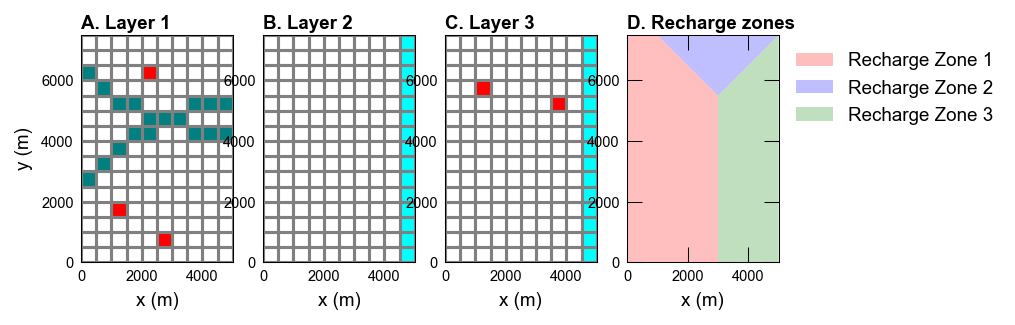

In [21]:
with styles.USGSMap():
    fig = plt.figure(figsize=(6, 10),dpi=150)
    ax = fig.add_subplot(4, 4, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0) ; pmv.plot_grid() ; pmv.plot_bc(name="WEL", kper=3) ; pmv.plot_bc(name="RIV")  # Wel, RIV
    title="Layer 1";letter=chr(ord("@")+1);styles.heading(letter=letter,heading=title,ax=ax);ax.set_xlabel("x (m)");ax.set_ylabel("y (m)")

    ax = fig.add_subplot(4, 4, 2, aspect="equal")
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=1) ; pmv.plot_grid() ; pmv.plot_bc(name="GHB") ; pmv.plot_bc(ftype="WEL", kper=3)  # GHB
    title = "Layer 2" ; letter = chr(ord("@") + 2) ; styles.heading(letter=letter, heading=title, ax=ax) ; ax.set_xlabel("x (m)")

    ax = fig.add_subplot(4, 4, 3, aspect="equal")
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=2) ;pmv.plot_grid() ; pmv.plot_bc(name="GHB") ; pmv.plot_bc(ftype="WEL", kper=3)   # GHB, WEL
    title = "Layer 3" ; letter = chr(ord("@") + 3) ; styles.heading(letter=letter, heading=title, ax=ax) ; ax.set_xlabel("x (m)")

    ax = fig.add_subplot(4, 4, 4, aspect="equal")
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax) ; pmv.plot_grid(linewidth=0)
    
    for ip, (p, fc) in enumerate([(recharge_zone_1, "r"), (recharge_zone_2, "b"), (recharge_zone_3, "g")]):
        xs, ys = p.exterior.xy ; ax.fill(xs, ys, alpha=0.25, fc=fc, ec="none", label=f"Recharge Zone {ip + 1}")
    ax.set_xlabel("x (m)")  ; styles.graph_legend(ax) ; title = "Recharge zones" ; letter = chr(ord("@") + 4)
    
    styles.heading(letter=letter, heading=title, ax=ax); ax.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show() ; fig.savefig(output_folder/'04_advtidal')

In [22]:
obsnames = gwf.obs[1].output.obs_names           ; print('obsnames:  ', obsnames)  
tsdata1  = gwf.obs[1].output.obs(f=obsnames[0])  ; ts1 = tsdata1.data ; ts1na = ts1.dtype.names[1:]
tsdata2  = gwf.obs[1].output.obs(f=obsnames[1])  ; ts2 = tsdata2.data ; ts2na = ts2.dtype.names[1:]
tsdata3  = gwf.ghb.output.obs()                  ; ts3 = tsdata3.data ; ts3na = ts3.dtype.names[1:]
print('ts.names_   ts1:',ts1na, '   ts2:', ts2na, '   ts3:', ts3na)  
print('tsdata 1-3:', tsdata3.__dict__.keys())

obsnames:   ['ex-gwf-advtidal.obs.head.csv', 'ex-gwf-advtidal.obs.flow.csv']
ts.names_   ts1: ('H1_13_8',)    ts2: ('ICF1',)    ts3: ('GHB_2_6_10', 'GHB_3_6_10', 'ESTUARY2', 'ESTUARY3')
tsdata 1-3: dict_keys(['integer', 'integerbyte', 'character', 'textbyte', 'verbose', 'obsnames', 'nobs', 'data'])


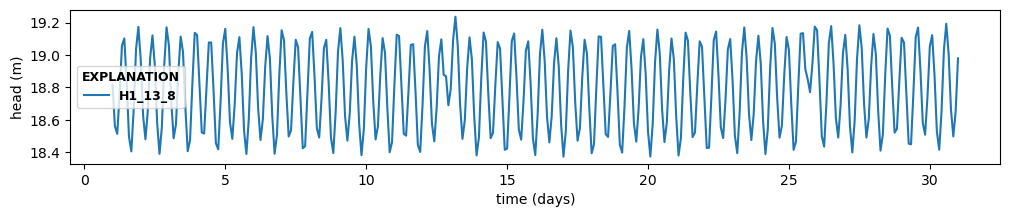

In [23]:
ts_na = ts1na;          fig, ax = plt.subplots(figsize=(12, 2))        ; ax.plot(ts1['totim']  ,ts1['H1_13_8'],  label=ts_na)  
ax.set_xlabel("time (days)") ; ax.set_ylabel("head (m)") ; styles.graph_legend(ax) ; plt.show()   

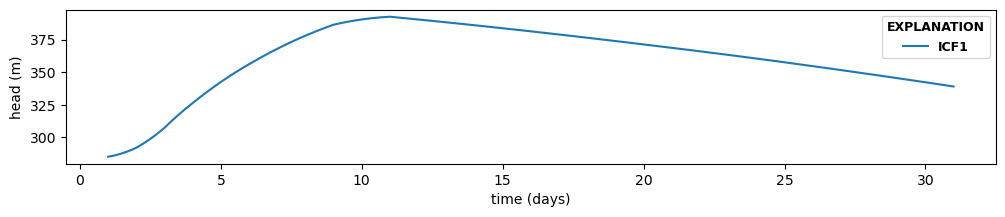

In [24]:
ts_na = ts2na;           fig, ax = plt.subplots(figsize=(12, 2))       ; ax.plot(ts1['totim'] ,ts2['ICF1'],label=ts_na)  
ax.set_xlabel("time (days)") ; ax.set_ylabel("head (m)") ; styles.graph_legend(ax) ; plt.show()

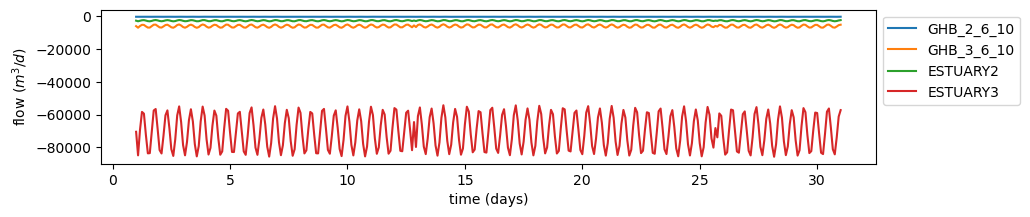

In [25]:
df = pd.DataFrame(ts3); df ; ax = df.plot(x="totim", y= list(ts3na) , kind="line", rot=0, figsize=(10,2)); 
ax.legend(bbox_to_anchor=(1.0, 1.0)); ax.set(xlabel="time (days)", ylabel="flow ($m^3/d$)"); plt.show()

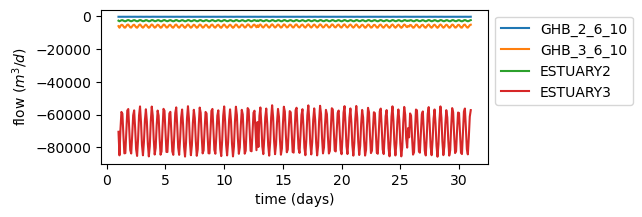

In [26]:
df = pd.DataFrame(ts3); df ; ax = df.plot(x="totim", y= list(ts3na) , kind="line", rot=0, figsize=(5,2)); 
ax.legend(bbox_to_anchor=(1.0, 1.0)); ax.set(xlabel="time (days)", ylabel="flow ($m^3/d$)"); plt.show()

In [27]:
def plot_ts(sim):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name)
        obsnames = gwf.obs[1].output.obs_names
        obs_list = [
            gwf.obs[1].output.obs(f=obsnames[0]),
            gwf.obs[1].output.obs(f=obsnames[1]),
            gwf.ghb.output.obs(),
        ]
        ylabel = ("head (m)", "flow ($m^3/d$)", "flow ($m^3/d$)")
        obs_fig = ("obs-head", "obs-flow", "ghb-obs")
        for iplot, obstype in enumerate(obs_list):
            fig = plt.figure(figsize=(6, 3))
            ax = fig.add_subplot()
            tsdata = obstype.data
            for name in tsdata.dtype.names[1:]:
                ax.plot(tsdata["totim"], tsdata[name], label=name)
            ax.set_xlabel("time (d)")
            ax.set_ylabel(ylabel[iplot])
            styles.graph_legend(ax)
            if plot_show:
                plt.show()
def plot_results(sim, silent=True):
    plot_grid(sim)
    plot_ts(sim)

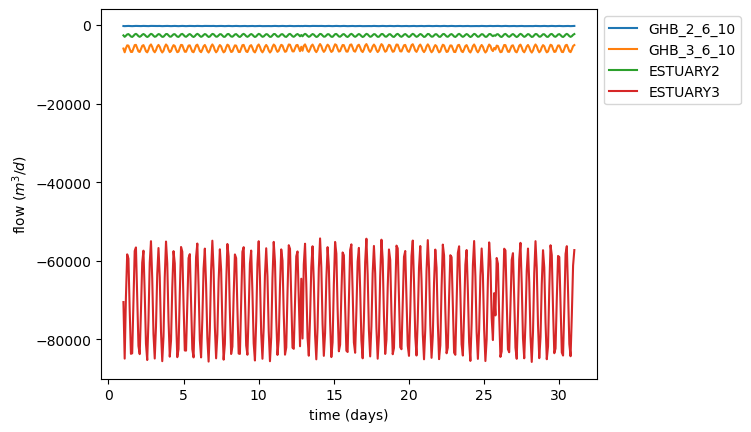

In [28]:
df = pd.DataFrame(ts3) 
ax = df.plot(x="totim", y= list(ts3na), kind="line")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set(xlabel="time (days)", ylabel="flow ($m^3/d$)")
plt.show()